# MarkLogic and NetworkX Demo

This notebook demonstrates fetching data from MarkLogic's triplestore using the SPARQL endpoint. NetworkX will then take the returned dataset and run graph algorithms against that subset of the graph.

*Note: This demo assumes that you have a configured MarkLogic Server with a demo user that can read/write data from MarkLogic Server. See <https://docs.marklogic.com/11.0/guide/installation-guide/en/procedures/installing-marklogic.html> for installation and user creation <https://docs.marklogic.com/11.0/guide/security-guide/en/securing-marklogic-server.html> if needed.*

## Inserting Graph Data into MarkLogic Server

MarkLogic allows you to create semantic graphs through the /v1/graphs REST API. For this example we are creating a simple social network utilizing SKOS.

In [ ]:
import requests 
from requests.auth import HTTPBasicAuth 

ttl = """
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix ex: <https://example.com/semantics/people#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

# Simple Social Graph
ex:Person       rdfs:isDefinedBy ex:Person ;
                a                rdfs:Class ;
                rdfs:label       "Person" ;
                skos:prefLabel   "Person" ;
                rdfs:subClassOf  skos:Concept .

ex:1            rdfs:isDefinedBy  1 ;
                a                 ex:Person ;
                skos:prefLabel    "Andrey Ohlsen" .                

ex:2            rdfs:isDefinedBy  2 ;
                a                 ex:Person ;
                skos:prefLabel    "Rodolphe Alexandersen" ;
                skos:broader      ex:1 .
                

ex:3            rdfs:isDefinedBy  3 ;
                a                 ex:Person ;
                skos:prefLabel    "Wilow Duckels" ;
                skos:broader      ex:1 .
                

ex:4            rdfs:isDefinedBy  4 ;
                a                 ex:Person ;
                skos:prefLabel    "Sheilakathryn Arkley" ;
                skos:broader      ex:2 .
                

ex:5            rdfs:isDefinedBy  5 ;
                a                 ex:Person ;
                skos:prefLabel    "Frank Grayley" ;
                skos:broader      ex:4 .
                
"""

response = requests.put('http://localhost:8000/v1/graphs?graph=https://example.com/semantics/people', 
            data = ttl,
            headers = { 'Content-Type': 'text/turtle' },
            auth = HTTPBasicAuth('user', 'password')) 

pprint(response)

## Reading Data from MarkLogic and Processing with NetworkX 

NetworkX is an an extensive graph algorithm library that can analyze a variety of graph data. We will be using NetworkX for our demo along with information stored in MarkLogic Server.

NetworkX requires its data structure to run the algorithms. NetworkX provides support for undirected, directed, undirected multi-graph, and directed multi-graph. The directed multi-graph can be used for  our examples below. This will ensure that we preserve the directionality of our triplestore and allow for multiple links between nodes.

The following code reaches out to MarkLogic's SPARQL endpoint and fetches a subset of the graph. Utilizing the DESCRIBE keyword in our SPARQL statement will give the necessary triples to build the graph and return a turtle encoded response. We then parse the turtle and convert it to a graph that can be used by NetworkX.


In [ ]:

from pprint import pprint

import networkx as nx

from rdflib import Graph, URIRef
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph

from SPARQLWrapper import SPARQLWrapper, POST, BASIC

sparql = SPARQLWrapper("http://localhost:8000/v1/graphs/sparql")
sparql.setMethod(POST)
sparql.setHTTPAuth(BASIC)
sparql.setOnlyConneg(True) # Disables the additional params being sent.
sparql.setCredentials("user", "password")

query = """
## query

PREFIX ex: <https://example.com/semantics/people#> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

DESCRIBE * FROM <https://example.com/semantics/people> WHERE {
  ?person a ex:Person ;
          skos:broader* ?knows .
}
"""

sparql.setQuery(query)
results = sparql.queryAndConvert()

g = Graph();
g.parse(data=results.serialize(), format="turtle")
mdg = rdflib_to_networkx_multidigraph(g)

## Drawing your graph

We can plot our graphs visually using NetworkX as well. There are multiple types of visualizations that you can use such as circular, random, planar, etc.

In [ ]:
nx.draw_planar(mdg, with_labels=True)

## Shortest Path

NetworkX can do shortest path calculations on the graph. The shortest path algorithm determines the least amount of hops to get between two nodes in the graph.

[rdflib.term.URIRef('https://example.com/semantics/people#5'),
 rdflib.term.URIRef('https://example.com/semantics/people#4'),
 rdflib.term.URIRef('https://example.com/semantics/people#2'),
 rdflib.term.URIRef('https://example.com/semantics/people#1')]


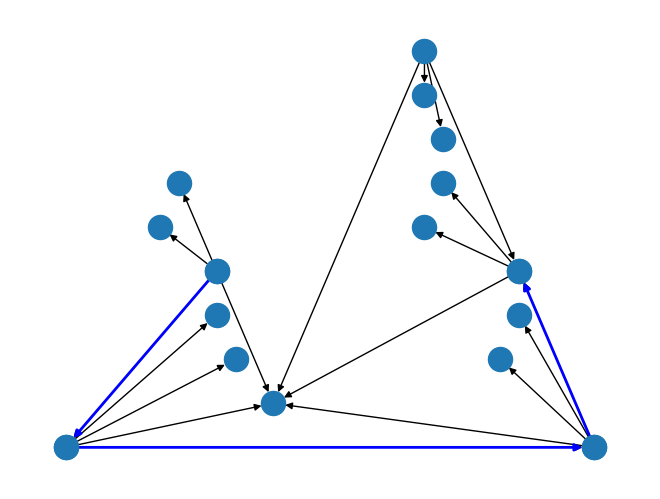

In [48]:
source = URIRef('https://example.com/semantics/people#5')
target = URIRef('https://example.com/semantics/people#1')

shortest_path = nx.shortest_path(mdg, source, target)

pprint(shortest_path)

# Visualize the Shortest Path
layout = nx.planar_layout(mdg)
nx.draw(mdg, layout)
path_edges = list(zip(shortest_path, shortest_path[1:]))
nx.draw_networkx_nodes(mdg, layout, nodelist = shortest_path)
nx.draw_networkx_edges(mdg, layout, edgelist = path_edges, edge_color = 'yellow', width = 2)

## Network Density

Network density is determined on how connected each nodes are within the group. NetworkX provides  a score between 0 and 1. Zero being an completely unconnected graph. One being a graph where every node connects to each other. 

In [ ]:
density = nx.density(mdg)
pprint(density)

## Centrality

Centrality measures the central a node is in a graph. There are a number of ways to calculate the level of importance of a node.

### Closeness Centrality

Utilizing shortest paths closeness centrality determines how central a node is based on the distance from other nodes. 

In [ ]:
pprint(nx.closeness_centrality(mdg))

### Degree Centrality

Degree centrality takes into consideration on how connected a node is within the graph. The more connections the higher the centrality.

In [ ]:
pprint(nx.degree_centrality(mdg))

## Components

###  Strongly Connected Components

In [ ]:
pprint(list(nx.strongly_connected_components(mdg)))

### Weakly Connected Components

In [ ]:
pprint(list(nx.weakly_connected_components(mdg)))

## Link Analysis

Link analysis focuses on the connections or relationships of nodes in the graph. Various scoring can be calculated based on the number of connections between nodes.

###  Page Rank

Page Rank Link Analysis provides a score on how connected each node is in the graph. A node that is has more links will have a higher page rank.

In [ ]:
pprint(nx.pagerank(mdg))

### Hits

Hits calculates two numbers based on the level of connectivity of a node. The scores are based on incoming and outgoing relationships.

In [ ]:
pprint(nx.hits(mdg))

## Communities

Communities are a grouping of nodes that are heavily connected. Use cases such as social networks are prime examples of communities. 

### Girvan-Newman Communities

The Girvan-Newman community algorithm takes into account the centrality of a node when detecting communities.

In [ ]:
import random

communities_generator = nx.community.girvan_newman(mdg)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
pprint(sorted(map(sorted, next_level_communities)))

# Visualize the Communities
pos = nx.planar_layout(mdg)
nx.draw(mdg, pos,node_color = 'k')

for node_set in next_level_communities:
    random_color = "#" + hex(random.randrange(0, 2**24))[2:]
    nx.draw_networkx_nodes(mdg, pos, nodelist = node_set, node_color = random_color)